Соберите отчет по результатам ЕГЭ в 2018-2019 году, используя данные
https://video.ittensive.com/python-advanced/data-9722-2019-10-14.utf.csv
и отправьте его в HTML формате по адресу support@ittensive.com, используя только Python.
В отчете должно быть:

1. общее число отличников (учеников, получивших более 220 баллов по ЕГЭ в Москве),
2. распределение отличников по округам Москвы,
3. название школы с лучшими результатами по ЕГЭ в Москве. 

Диаграмма распределения должна быть вставлена в HTML через data:URI формат (в base64-кодировке).

Дополнительно: приложите к отчету PDF документ того же содержания (дублирующий письмо).


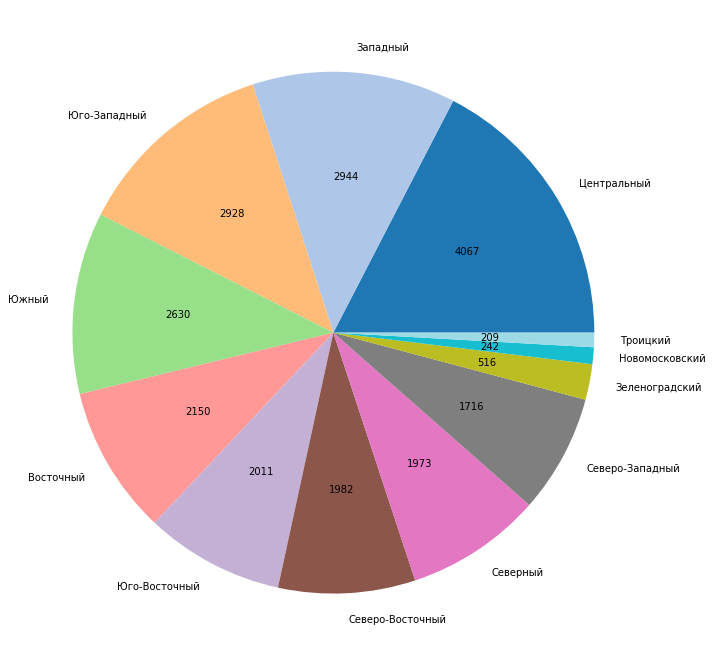

In [2]:
#Соберите отчет по результатам ЕГЭ в 2018-2019 году, используя данные
#https://video.ittensive.com/python-advanced/data-9722-2019-10-14.utf.csv

import pandas as pd
import matplotlib.pyplot as plt
import binascii  # для преоб. изобр. из бинарного формата в текстовый
from io import BytesIO # для временного хран. изображения
import pdfkit  # для сборки отчета в PDF файл
from jinja2 import Template  # для шаблонов 


# загрузим данные из csv файла в датафрейм пандас
data = pd.read_csv("https://video.ittensive.com/python-advanced/data-9722-2019-10-14.utf.csv", delimiter=";")
data["AdmArea"] = data["AdmArea"].apply(lambda x: x.split(' ')[0])  # преобразуем название округов (отсечем все кроме названий)
data = data.set_index("YEAR")  # установим год как индекс 
data = data.loc["2018-2019"] # сделаем срез данных, выбрав тем самым необходимый год 2018-2019
# print(data.head())

# сгруппируем по округам, просуммируем количесво отличников, чтобы прстроить круговую диаграмму 
data_gr_area = data.groupby("AdmArea")["PASSES_OVER_220"].sum().sort_values(ascending=False)

# отрисуем диаграмму
fig = plt.figure(figsize=(12, 12))
area = fig.add_subplot(1, 1, 1)
total = sum(data_gr_area) # необходимо, чтобы нанести на диаграмму число отличников в каждом районе
data_gr_area.plot.pie(ax=area, label="", cmap="tab20", autopct=lambda x: int(round(total * x/100)))
# plt.savefig("pie-shcool-PASSES_OVER_220.png")  # сохранение отрисованной диаграммы, если необходимо сохранить дополнительно раскомментируйте 
#plt.show()

img = BytesIO() # объект BytesIO для временного хранения изображения, чтобы не сохранять и не удалять из временных файлов
plt.savefig(img) # сохранение в опер.память

# закодируем изображение в base64, с обязательным указанием кодировки UTF-8
img = 'data:image/png;base64,' + binascii.b2a_base64(img.getvalue(),
                                                    newline=False).decode('UTF-8')

pd.set_option('display.max_colwidth', 1000) # увеличим макс. кол-во сиволов отображения строк в датафрейме до 1000, через настройки пандас
best_school = data.sort_values("PASSES_OVER_220", ascending=False)
# print(best_school.head(10))

# произведем некоторые требуемые по условию вычисления, для дальнейшей вставки в шаблон отчета
best_school = best_school["EDU_NAME"].iloc[0]
sum_PASSES_OVER_220 = data["PASSES_OVER_220"].sum()

# print(best_school)
# print(sum_PASSES_OVER_220)
# print(img)

# напишем HTML шаблон
html_template= '''<html><head>
    <title>Статистика по отличникам ЕГЭ в Москве за 2018-2019 год</title>
    <meta charset="UTF-8"/>
</head>
<body>
<h1  align="center">Распределение отличников ЕГЭ по округам Москвы</h1>
<p align="center"><img src="{{data.image}}" alt="Диаграмма распределение отличников по округам Москвы"/></p>
<p   style="font-size:150%;margin-left:5%;margin-right:5%"> <b> Общее число отличников ЕГЭ в Москве за 2018-2019:</b> {{data.sum_PASSES_OVER_220}} человек.</p>
<p style="font-size:150%;margin-left:5%;margin-right:5%"> <b>Название учебного заведения с наибольшим количеством отличников:</b> {{data.best_school}}</p>

{{data.table}}
</body>
</html>
'''
# соберем HTML код, при помощи шаблона
html = Template(html_template).render(data = {
    'image': img,
    'sum_PASSES_OVER_220': sum_PASSES_OVER_220,
    'best_school': best_school
})
# сконфигурируем pdfkit 
config = pdfkit.configuration(wkhtmltopdf="D:/wkhtmltopdf/bin/wkhtmltopdf.exe")
options = {
    'page-size': 'A4',
    'header-right': '[page]'
}
# создадим отчет при промощи pdfkit, из ранее написаного HTML кода
pdfkit.from_string(html, 'stat_school_best_ege_2018_2019.pdf',
                   configuration=config, options=options)
# запишем HTML файл отчета, он понадобится во второй части решения задания 
with open("stat_school_best_ege_2018_2019.html", 'w', encoding='UTF-8') as f:
    f.write(html)
# print(html)


Отправьте его в HTML формате по адресу support@ittensive.com, используя только Python.
Диаграмма распределения должна быть вставлена в HTML через data:URI формат (в base64-кодировке).
Дополнительно: приложите к отчету PDF документ того же содержания (дублирующий письмо).

Настройки для отправки через почтовый сервер gmail
smtp.gmail.com Требуется SSL: да Требуется аутентификация: да Порт для SSL: 465


In [3]:
import smtplib # для работы с почтовым сервером
from email import encoders # для кодировки отчета в Base64
from email.mime.text import MIMEText # для работы письмом 
from email.mime.base import MIMEBase 
from email.mime.multipart import MIMEMultipart

# после подкл. необход. библ. начнем формировать письмо 
letter = MIMEMultipart()
# зададим все заголовки, нам нужны заголовки "From", "Subject", "To"
letter["From"] = "from@gmail.com"
letter["Subject"] = "Отчет. Распределение отличников ЕГЭ по округам Москвы"
letter["Content-Type"] = "text/html; charset=utf-8"
letter["To"] = "to@yandex.ru"

# после этого добавим содержание к телу письма
letter.attach(MIMEText(open("stat_school_best_ege_2018_2019.html", 'r', # наш HTML файл отчета
                           encoding="UTF-8").read(), 'html')) 
# также можно назначит html как строку, но работать с готовыми файлами проще и быстрее.

# после этого доп. прикрепим pdf док. созданый из этого HTML к самому письму как вложение attachement
# для этого используем  MINEBase и обязательно ставим заголовок Content-Disposition, это позволяет скачать его как нужный файл, иначе никак не передается
attachement = MIMEBase('application', 'pdf')
attachement.set_payload(open('stat_school_best_ege_2018_2019.pdf', 'rb').read())
attachement.add_header('Content-Disposition',
                     'attachement; filename="stat_school_best_ege_2018_2019.pdf"')

# теперь переобразуем бинарные файлы в base64 формат и прикрепим к письму
encoders.encode_base64(attachement)
letter.attach(attachement)

# все готово для отправки письма, зададим логин и пароль и подключимся к smtp серверу

# user = ""  # логин на почтовом сервере
# password = "" # пароль
server = smtplib.SMTP_SSL("smtp.gmail.com", 465)
server.login(user, password)
# отправим письмо вызывав as_string у объекта MINEMultipart 
# мы создали этот объект, его заполнили полями и телом письма и вложением, теперь нам нужно перевести его в текстовый вид, 
# т.е. отправляем по факту текст, а библиотеки позволяют нам, правильно сформировать этот текст учитывая все Base64 кодировки и все соглашения который достигнуты в RFC спецификации отправки почты
server.sendmail("from@gmail.com", "to@yandex.ru",
               letter.as_string())
server.quit()  # закрываем соединение 

(221,
 b'2.0.0 closing connection g4-20020a2ea4a4000000b00279d73cdf83sm186333ljm.128 - gsmtp')